# Анализ продаж видеоигр

**Задача:**

Изучить данные, оставив только те, что будут полезны для выявления определяющих успешность игры закономерностей. Это позволит сделать ставку на потенциально популярный продукт и спланировать будущие рекламные кампании.

**Ход исследования:**

Предобработка данных:
- Обработка столбцов (приведение к нижнему регистру, добавление вспомогательных)
- Приведение значений к правильному типу данных
- Обработка особенностей и пропусков в значениях

Исследовательский анализ:
- Выявление платформ с наибольшим количеством проданных игр
- Выявление актуальных платформ и периода для прогнозирования
- Расчет корреляции между отзывами об играх и общими продажами для актуальных платформ
- Выявление наиболее прибыльных жанров игр
- Составление портрета пользователя каждого региона

Проверка гипотез:
- О равенстве средних пользовательских рейтингов платфом PC и Xbox One
- О неравенстве средних пользовательских рейтингов жанров Action и Sports

**Описание данных:**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.


## Предобработка данных

Импорт библиотек.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns

Чтение и запись в переменную датафрейма из файла.

In [2]:
data = pd.read_csv('/datasets/games.csv')

In [3]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведем названия столбцов к нижнему регистру.

In [4]:
data.columns = data.columns.str.lower()

Выведем информацию о датафрейме, а также количество строк с пропусками.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [6]:
pd.DataFrame(round(data.isna().mean()*100)).style.background_gradient('coolwarm')

,0
name,0.000000
platform,0.000000
year_of_release,2.000000
genre,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000
other_sales,0.000000
critic_score,51.000000
user_score,40.000000


Проверим, есть ли в датафрейме дубликаты. Дубликатами будем считать строки, для которых одинаковое название игры и платформа:

In [7]:
data[data.duplicated(subset=['name', 'platform'])]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.0,0.13,0.02,0.10,83.0,8.5,T
4127,Sonic the Hedgehog,PS3,NaN,Platform,0.0,0.48,0.00,0.00,43.0,4.1,E10+
11715,Need for Speed: Most Wanted,PC,2012.0,Racing,0.0,0.06,0.00,0.02,82.0,8.5,T
14244,NaN,GEN,1993.0,NaN,0.0,0.00,0.03,0.00,NaN,NaN,NaN
16230,Madden NFL 13,PS3,2012.0,Sports,0.0,0.01,0.00,0.00,83.0,5.5,E


Удалим данные дубликаты.

In [8]:
data = data.drop_duplicates(subset=['name', 'platform']).reset_index(drop=True)

Помимо того, что не во всех столбцах у данных указан правильный тип, также заметим, что есть несколько пропусков в столбце с названием игры `'name'` и годом выпуска `'year_of_release'`, а также большое количество пропусков в столбцах с рейтингом игры `'rating'`, оценками пользователей `'user_score'` и критиков `'critic_score'`.

Так как пропусков названий игр и годов выпусков мало, удалим их - это не повлияет на качество данных.

Пропуски в оценках пользователей и критиков заполнять не будем - их достаточно много, синтетические данные сильно повлияют на результат исследования.

Пропуски в рейтинге игры заполним значением "not defined" (не определен), так как логичного метода для заполнения этих пропусков нет. Пропуски вероятнее всего связаны с тем, что:
- организация ESRB появилась только в 1994 году, тогда как в датафрейме есть игры, выпущенные до 1994 года (начиная с 1980)
- не существует обязательного требования, чтобы всем играм был присвоен рейтинг (хотя современные платформы и стараются не пропускать игры без рейтинга)
- каким-то из игр рейтинг еще не был присвоен
- также нельзя исключать ошибок при заполнении датафрейма


In [9]:
data = data.dropna(subset=['year_of_release', 'name'])

Далее поменяем типы данных в столбцах и заполним пропуски в столбце с рейтингом игры:

In [10]:
data['rating'].fillna('Not defined', inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int64')
data['user_score'] = data['user_score'].astype('float64')

ValueError: could not convert string to float: 'tbd'

Ошибка сигнализирует о том, что в столбце с оценками пользователей есть значение "tbd" - to be determined, то есть рейтинг еще не определен. Выявление причины заполнения таким значением требует дополнительных данных, возможно это связано с тем, что для некоторых игр нет достаточного количества пользовательских оценок для присвоения ей справедливой оценки.

Убедимся, что помимо пропусков "nan" и еще не заполненных значений "tbd", аномалий больше нет.

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Посмотрим, сколько в столбце с пользовательскими оценками значений "tbd".

In [12]:
len(data.query('user_score == "tbd"'))

2376

Так как фактически для этих игр пользовательских оценок нет, присвоим таким строкам значение nan, после чего поменяем тип данных в столбце.

In [13]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = float('nan')
data['user_score'] = data['user_score'].astype('float64')

Еще раз выведем информацию о датафрейме, убедимся что тип данных во всех столбцах теперь верный.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16441 entries, 0 to 16709
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16441 non-null  object 
 1   platform         16441 non-null  object 
 2   year_of_release  16441 non-null  int64  
 3   genre            16441 non-null  object 
 4   na_sales         16441 non-null  float64
 5   eu_sales         16441 non-null  float64
 6   jp_sales         16441 non-null  float64
 7   other_sales      16441 non-null  float64
 8   critic_score     7980 non-null   float64
 9   user_score       7460 non-null   float64
 10  rating           16441 non-null  object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Добавим столбец с суммарным количеством продаж для каждой игры. Для этого сложим продажи для каждого региона.

In [15]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

---

## Исследование данных

### Количество выпущенных игр по годам

Посмотрим, как распределяется количество выпущенных игр в зависимости от года.

In [16]:
data_by_year = data.groupby('year_of_release')['name'].count()

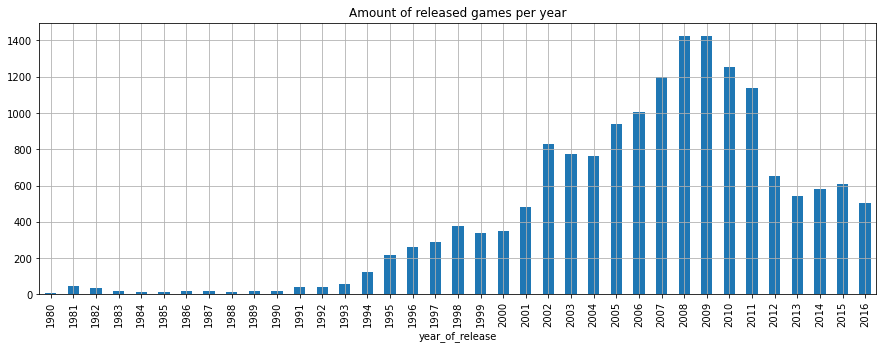

In [17]:
data_by_year.plot(kind='bar', grid=True, figsize=(15,5))
plt.title('Amount of released games per year')
plt.show()

Заметим, что с 1980 практически неизменно с каждым годом выпускалось все больше и больше игр, пик по количеству выпущенных игр пришелся на 2008-2009 год, тогда их было выпущено чуть больше 1400, после чего количество ежегодно выпускаемых игр уменьшалось, и в итоге уменьшилось более чем в 2 раза, по сравнению с максимальным значением.

In [18]:
temp = data.drop_duplicates(subset='name').reset_index(drop=True)

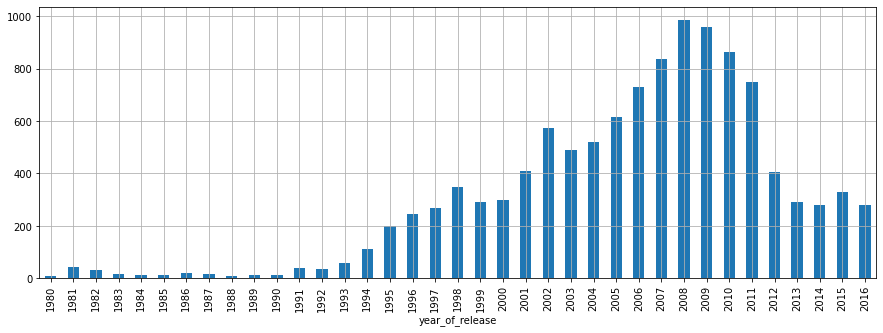

In [19]:
temp.groupby('year_of_release')['name'].count().plot(kind='bar', grid=True, figsize=(15,5))
plt.show()

Для нашего исследования будет достаточно учесть данные с 2012-2013 по 2016 год, так как динамика в эти годы практически неизменна. Точный диапазон лет, для которого будем проводить исследование, определим дальше.

---

### Изменение продаж по платформам

Посмотрим, как изменяется суммарное количество продаж для 15 наиболее популярных платформ от года к году.

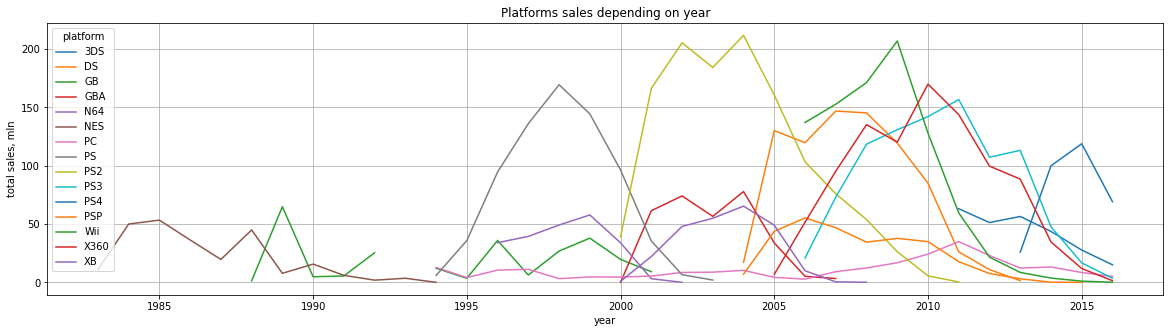

In [20]:
top_platforms = data.groupby('platform')['total_sales'].\
sum().sort_values(ascending=False).head(15).index

data.query('platform in @top_platforms')\
.pivot_table(index='year_of_release', columns='platform',values='total_sales', aggfunc='sum')\
.plot(grid=True, figsize=(20,5), ylabel=('total sales, mln'), xlabel=('year'), title=('Platforms sales depending on year'))

plt.show()

**Отметим следующее:**
- "срок жизни" для каждой платформы можно разделить на 2 части: примерно половину этого срока популярность и количество продаваемых игр растет, после чего происходит уменьшение количества продаж.
- "сроки жизни" у платформ немного различаются, но в среднем с момента появления платформы и до момента потери ее актуальности проходит 7-10 лет.
- при этом есть особо удачные платформы, такие как PC (игры выпускались с 1994 и в 2016 продаются примерно так же часто) и PS2 ("срок жизни" составил более 10 лет).
- к 2016 году все платформы, для которых еще выпускаются и продаются игры, находятся во второй стадии своей "жизни" - их актуальность идет на спад.

Попробуем выделить из общего списка платформ те, которые еще актуальны. Будем считать, что актуальный срок, который нужно учитывать для прогнозирования - последние 4 года (половина от среднего общего срока жизни платформы).

In [21]:
data_of_platforms = data.query('year_of_release >= 2013')\
.groupby(['platform', 'year_of_release'])['total_sales'].agg(total_sales = 'sum')

data_of_platforms

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.38
         2014                   13.28
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.14
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

Таких платформ достаточно много. Сократим их количество: будем считать, что актуальные платформы те - для которых в 2016 году продавалось не менее 10 миллионов копий игр.

In [22]:
data_of_platforms = data_of_platforms.query('year_of_release == 2016 & total_sales > 10')
data_of_platforms

,,total_sales
platform,year_of_release,
3DS,2016,15.14
PS4,2016,69.25
XOne,2016,26.15


Список все еще актуальных платформ состоит из трех значений: 3DS (Nintendo), PS4 (Sony), XOne (Microsoft).

In [23]:
actual_platforms = data_of_platforms.index.get_level_values(0).unique().tolist()
actual_platforms

['3DS', 'PS4', 'XOne']

Построим график количества продаж по годам для этих платформ за актуальный (2013-2016) период.

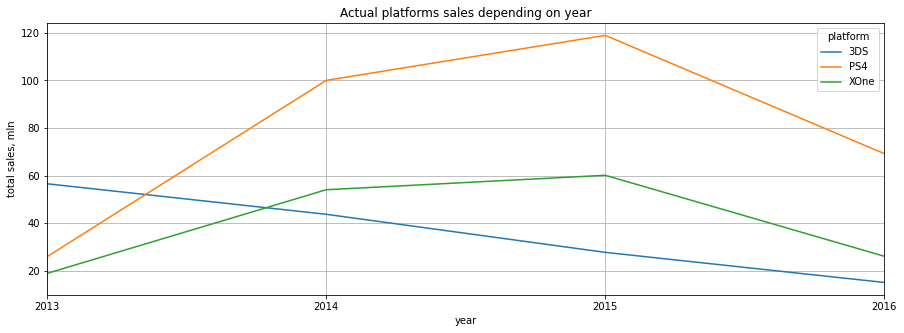

In [24]:
data.query('platform in @actual_platforms')\
.pivot_table(index='year_of_release', columns='platform',values='total_sales', aggfunc='sum')\
.plot(grid=True, figsize=(15,5), ylabel=('total sales, mln'), 
      xticks=(2013,2014,2015,2016), xlim=(2013,2016), xlabel=('year'), 
      title=('Actual platforms sales depending on year'))

plt.show()

Видим, что платформа 3DS теряет свою актуальность практически линейно, и скорее всего полностью потеряет свою актуальность в 2017. Платформа, обладающая наибольшим запасом по "времени жизни" - PS4. Начавшееся после 2015 года падение количества продаж, возможно, связано с тем, что для 2016 года данные могут быть неполными.

Также построим боксплоты для актуальных платформ за актуальный (2013-2016) период.

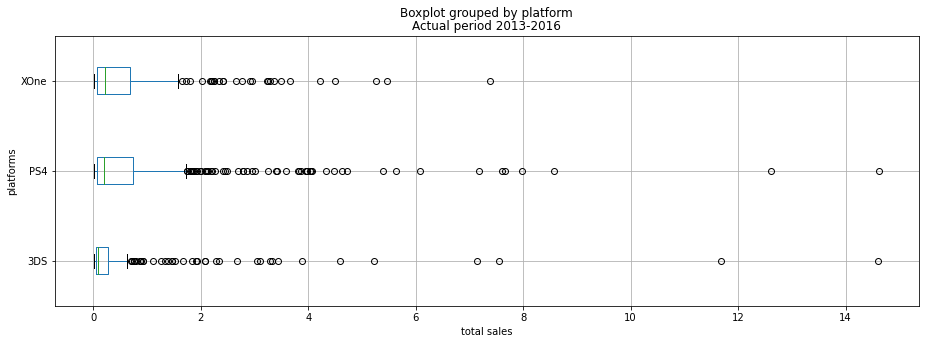

In [25]:
actual_period_data = data.query('year_of_release >=2013 & platform in@actual_platforms')
actual_period_data.boxplot(column='total_sales', by='platform', grid=True, figsize=(15,5), vert=False)
plt.ylabel('platforms')
plt.xlabel('total sales')
plt.title('Actual period 2013-2016')
plt.show()

Видим, что медианное значение продаж у XOne и PS4 выше, чем у 3DS. При этом сами ящики и усы у XOne и PS4 также ощутимо больше, чем у 3DS. Это свидетельствует о большем разбросе общего числа продаж для этих двух платформ. Также отметим, что у PS4 и 3DS есть успешные игры, продажи которых превысили 10 млн копий, у XOne таких игр нет.

---

### Корреляция отзывов и продаж

Посмотрим, есть ли зависимость между оценками пользователей и количеством продаж, а также между оценками критиков и количеством продаж.

Выведем графики рассеяния для этих величин, а также посчитаем коэффициенты корреляции.

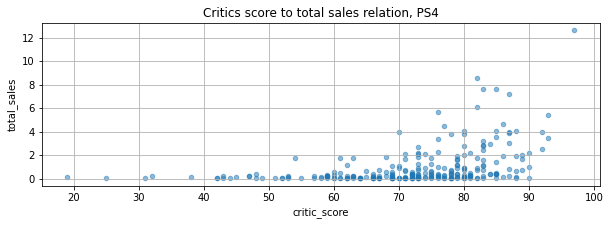

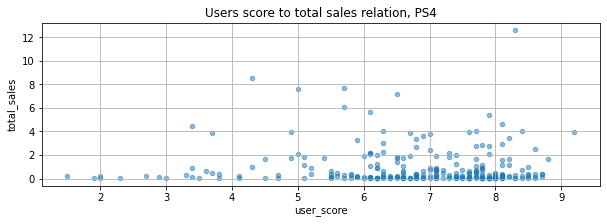

Корреляция между оценками критиков и общими продажами для PS4: 0.406567902061781
Корреляция между оценками пользователей и общими продажами для PS4: -0.031957110204556376


In [26]:
PS4_data = actual_period_data.query('platform == "PS4"')

PS4_data.plot(kind='scatter', x='critic_score', y='total_sales', 
              figsize=(10,3), grid=True, alpha=0.5, title='Critics score to total sales relation, PS4')
plt.show()

PS4_data.plot(kind='scatter', x='user_score', y='total_sales', 
              figsize=(10,3), grid=True, alpha=0.5, title='Users score to total sales relation, PS4')
plt.show()

print('Корреляция между оценками критиков и общими продажами для PS4:',
      PS4_data['total_sales'].corr(PS4_data['critic_score']))
print('Корреляция между оценками пользователей и общими продажами для PS4:',
      PS4_data['total_sales'].corr(PS4_data['user_score']))

Видим, что оценки критиков не сильно, но влияют на количество продаж (на самом деле, возможно не учитывается еще какой-то другой параметр, который оказывает такое влияние). Между пользовательскими оценками и продажами взаимосвязи нет совсем.

Аналогичные графики и расчеты проведем для платформы 3DS.

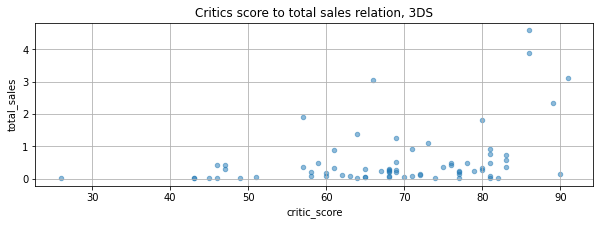

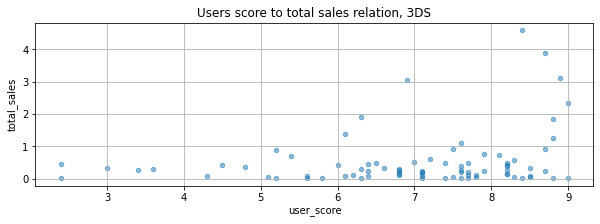

Корреляция между оценками критиков и общими продажами для 3DS: 0.35705661422881035
Корреляция между оценками пользователей и общими продажами для 3DS: 0.24150411773563016


In [27]:
DS_data = actual_period_data.query('platform == "3DS"')

DS_data.plot(kind='scatter', x='critic_score', y='total_sales',
             figsize=(10,3), grid=True, alpha=0.5, title='Critics score to total sales relation, 3DS')
plt.show()

DS_data.plot(kind='scatter', x='user_score', y='total_sales', figsize=(10,3), 
             grid=True, alpha=0.5, title='Users score to total sales relation, 3DS')
plt.show()

print('Корреляция между оценками критиков и общими продажами для 3DS:',
      DS_data['total_sales'].corr(DS_data['critic_score']))
print('Корреляция между оценками пользователей и общими продажами для 3DS:',
      DS_data['total_sales'].corr(DS_data['user_score']))

Заметим, что для платформы 3DS оценки пользователей влияют на количество продаж гораздо сильнее, чем в случае с PS4.

И, наконец, аналогичные графики и расчеты для платформы XOne.

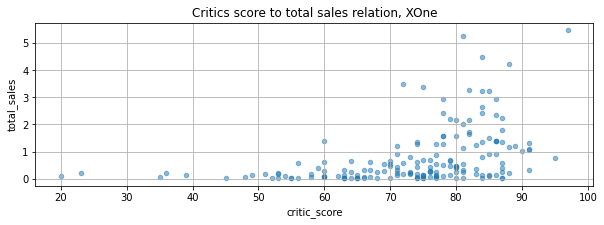

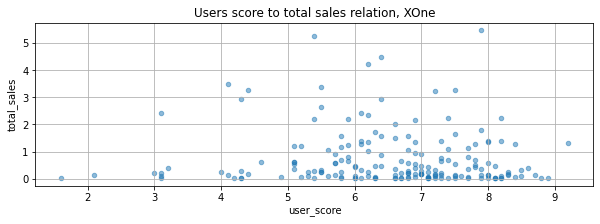

Корреляция между оценками критиков и общими продажами для XOne: 0.41699832800840175
Корреляция между оценками пользователей и общими продажами для XOne: -0.06892505328279412


In [28]:
XOne_data = actual_period_data.query('platform == "XOne"')

XOne_data.plot(kind='scatter', x='critic_score', y='total_sales', 
               figsize=(10,3), grid=True, alpha=0.5, title='Critics score to total sales relation, XOne')
plt.show()

XOne_data.plot(kind='scatter', x='user_score', y='total_sales', 
               figsize=(10,3), grid=True, alpha=0.5, title='Users score to total sales relation, XOne')
plt.show()

print('Корреляция между оценками критиков и общими продажами для XOne:',
      XOne_data['total_sales'].corr(XOne_data['critic_score']))
print('Корреляция между оценками пользователей и общими продажами для XOne:',
      XOne_data['total_sales'].corr(XOne_data['user_score']))

Влияние пользовательских оценок и оценок критиков на общее количество продаж для XOne сопоставимо с данными параметрами для PS4.

Для всех рассматриваемых платформ есть прямая, но слабая корреляция между оценками критиков и общим количеством продаж. Влияние оценок пользователей на количество продаж для платформ PS4 и XOne практически нулевое, при этом, в случае с 3DS, влияние, хоть и небольшое, но есть.

---

### Распределение количества игр и продаж по жанрам

Посмотрим, какие жанры самые популярные, а также самые прибыльные с точки зрения количества проданных копий игр. Рассмотрим как изначальный датафрейм (1980-2016), так и датафрейм за актуальный период (2013-2016).

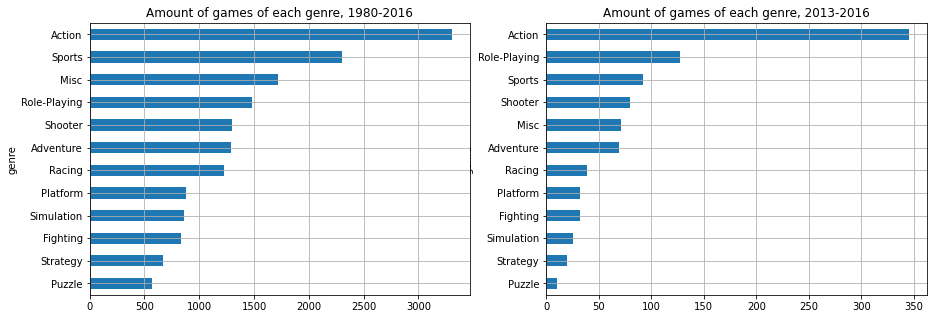

In [29]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,2)
actual_period_data.groupby('genre')['name'].agg('count').sort_values()\
.plot(kind='barh', grid=True, title=('Amount of games of each genre, 2013-2016'))

plt.subplot(1,2,1)
data.groupby('genre')['name'].agg('count').sort_values()\
.plot(kind='barh', grid=True, title=('Amount of games of each genre, 1980-2016'))
plt.show()


Вне зависимости от выбранных временных рамок, самым популярным жанром игр является Action. В актуальный период вторым по популярности жанром стал Role-Playing. Самым непопулярным жанром игр неизменно остается Puzzle.

Далее проанализируем, какой жанр является самым прибыльным. Рассмотрим как изначальный датафрейм (1980-2016), так и с актуальными данными (2013-2016).

Данные за весь период (1980-2016):

In [30]:
data.groupby('genre')['total_sales'].agg(['count', 'mean', 'median']).sort_values(by=['median', 'mean'], ascending=False)

,count,mean,median
genre,,,
Platform,878,0.940262,0.27
Shooter,1296,0.803519,0.24
Sports,2305,0.568182,0.22
Fighting,837,0.528865,0.21
Racing,1224,0.590000,0.19
Action,3307,0.519057,0.19
Role-Playing,1481,0.628683,0.18
Misc,1721,0.459204,0.16
Simulation,857,0.452695,0.15


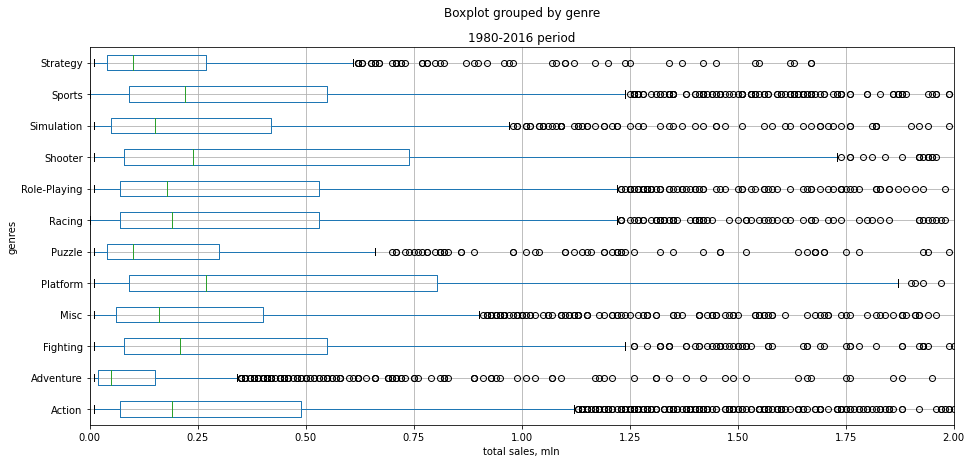

In [31]:
data.boxplot(column='total_sales', by='genre', grid=True, vert=False, figsize=(15,7))
plt.xlim(0,2)
plt.ylabel('genres')
plt.xlabel('total sales, mln')
plt.title('1980-2016 period')
plt.show()

Видим, что хотя игр в жанре Platform намного меньше, чем игр в жанре Action, медианное значение количества продаж - наибольшее, составляет 0.27 миллионов копий. Самый популярный (в плане выпускаемых игр) жанр Action только на 6 месте, с медианным значением в 0.19 миллионов копий. Жанр игр Adventure продается хуже всего. На боксплоте можно увидеть, что "ящик" для жанра Platform также является самым большим.

Посмотрим, поменялся ли популярный жанр в актуальном периоде (2013-2016):

In [32]:
actual_period_data.groupby('genre')['total_sales'].agg(['count', 'mean', 'median'])\
.sort_values(by=['median', 'mean'], ascending=False)

,count,mean,median
genre,,,
Shooter,80,1.861875,1.015
Sports,92,0.914891,0.345
Platform,32,0.544063,0.245
Racing,39,0.562308,0.230
Role-Playing,127,0.841811,0.200
Fighting,32,0.603437,0.155
Action,345,0.485362,0.120
Misc,71,0.320000,0.120
Simulation,25,0.458000,0.100


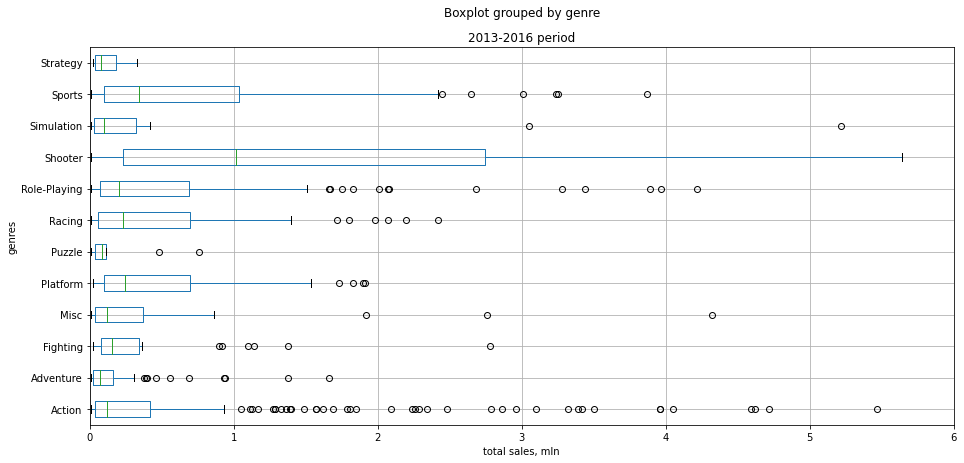

In [33]:
actual_period_data.boxplot(column='total_sales', by='genre', grid=True, vert=False, figsize=(15,7))
plt.xlim(0,6)
plt.ylabel('genres')
plt.xlabel('total sales, mln')
plt.title('2013-2016 period')
plt.show()

Ситуация изменилась - с 2013 по 2016 год самым прибыльным жанром стал Shooter, медианное значение проданных копий превысило 1 млн, также в топ-2 вошел жанр Sports, Platform только на третьем месте. Самый выпускаемый жанр игр Action откатился на 7 место. Жанр игр Adventure остается наименее прибыльным. На боксплоте также видно, что "ящик" жанра Shooter сильно больше всех остальных.

### Портрет пользователя для каждого региона

Попробуем составить портрет пользователя для каждого региона - NA (North America), EU (European Union), JP (Japan). Выведем графики с 5 наиболее популярными платформами, жанрами, а также посмотрим, в игры какого рейтинга в каждом из регионов играют чаще всего.

**Северо-американский регион:**

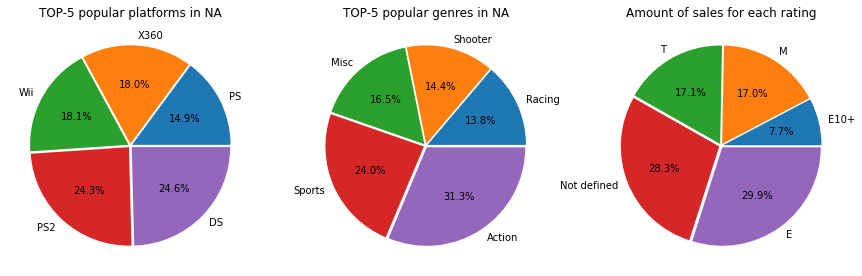

In [34]:
NA_region_data = data.query('na_sales > eu_sales & na_sales > jp_sales & na_sales > other_sales')

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
labels = NA_region_data.groupby('platform')['platform'].count().sort_values().tail(5).index
values = NA_region_data.groupby('platform')['platform'].count().sort_values().tail(5)
plt.pie(values, labels = labels,autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular platforms in NA')

plt.subplot(1,3,2)
labels = NA_region_data.groupby('genre')['genre'].count().sort_values().tail(5).index
values = NA_region_data.groupby('genre')['genre'].count().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular genres in NA')

plt.subplot(1,3,3)
labels = NA_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5).index
values = NA_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('Amount of sales for each rating')

plt.show()

Игроки из северо-американского региона предпочитают Wii, X360, PS, PS2 и DS (самая популярная платформа). Самый популярный жанр игры - Action, самый непопулярный - Racing. Большинство купленных игр обладают рейтингом E (Everyone). При этом практически у трети игр рейтинга нет.

**Европейский регион:**

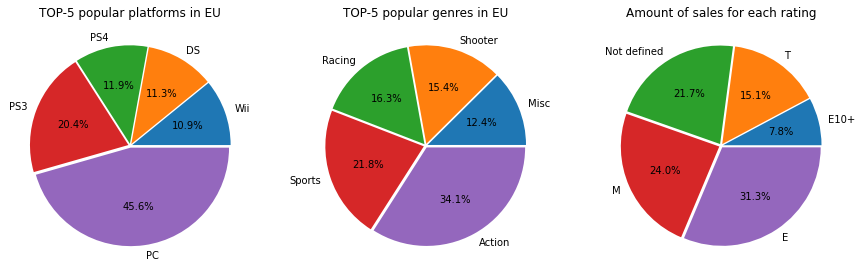

In [35]:
EU_region_data = data.query('eu_sales > na_sales & eu_sales > jp_sales & eu_sales > other_sales')

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
labels = EU_region_data.groupby('platform')['platform'].count().sort_values().tail(5).index
values = EU_region_data.groupby('platform')['platform'].count().sort_values().tail(5)
plt.pie(values, labels = labels,autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular platforms in EU')

plt.subplot(1,3,2)
labels = EU_region_data.groupby('genre')['genre'].count().sort_values().tail(5).index
values = EU_region_data.groupby('genre')['genre'].count().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular genres in EU')

plt.subplot(1,3,3)
labels = EU_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5).index
values = EU_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('Amount of sales for each rating')

plt.show()

Игроки из европейского региона предпочитают Wii, DS, PS4, PS3 и PC (самая популярная платформа). Самый популярный жанр игры - также Action, самый непопулярный - Misc. Большинство купленных игр также обладают рейтингом E (Everyone). При этом более 20% игр не обладает никаким рейтингом.

**Японский регион:**

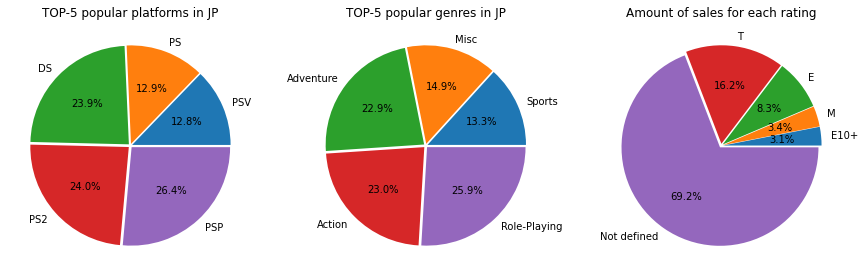

In [36]:
JP_region_data = data.query('jp_sales > eu_sales & jp_sales > na_sales & jp_sales > other_sales')

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
labels = JP_region_data.groupby('platform')['platform'].count().sort_values().tail(5).index
values = JP_region_data.groupby('platform')['platform'].count().sort_values().tail(5)
plt.pie(values, labels = labels,autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular platforms in JP')

plt.subplot(1,3,2)
labels = JP_region_data.groupby('genre')['genre'].count().sort_values().tail(5).index
values = JP_region_data.groupby('genre')['genre'].count().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('TOP-5 popular genres in JP')

plt.subplot(1,3,3)
labels = JP_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5).index
values = JP_region_data.groupby('rating')['total_sales'].sum().sort_values().tail(5)
plt.pie(values, labels = labels, autopct = '%1.1f%%', explode=(0.02,0.02,0.02,0.02,0.02))
plt.title('Amount of sales for each rating')

plt.show()

Игроки из японского региона предпочитают PSV, PS, DS, PS2 и PSP (самая популярная платформа). Самый популярный жанр игры - Role-Playing, самый непопулярный - Sports. Практически 70% игр в японском регионе не обладают рейтингом ESRB - скорее всего это связано с тем, что в Японии существует своя система рейтинга - CERO, и большинство покупаемых игр в регионе обладают именно этим рейтингом. При этом, если отбросить игры, которые не обладают рейтингом - самым популярным рейтингом является T (Teen), а не Everyone, как в Северной Америке и Европе.

## Проверка гипотез

**Проверим две гипотезы:**
1. О равенстве средних пользовательских рейтингов платформ Xbox One и PC.
2. О неравенстве средних пользовательских рейтингов жанров Action и Sports.

### Гипотеза для платформ Xbox One и PC

**Формулировка гипотезы:** средние пользовательские рейтинги в актуальном (2013-2016) периоде для платформ Xbox One и PC одинаковые.

В данном случае:

- H0 (нулевая гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC равны.
- H1 (альтернативная гипотеза) - средние пользовательские рейтинги платформ Xbox One и PC неравны.
- значение alpha (уровень значимости) = 0.01.
- проводим тест о равенстве среднего двух ГС (генеральных совокупностей), при этом считаем, что их дисперсии неравны.

Если значение p-value для проводимого теста будет меньше уровня значимости, у нас будут основания полагать, что нулевую гипотезу (о равенстве средних) можно отвергнуть.

In [37]:
pc_data = data.query('year_of_release >= 2013 & platform == "PC"').dropna(subset=['user_score'])
xone_data = data.query('year_of_release >= 2013 & platform == "XOne"').dropna(subset=['user_score'])

array_pc = pc_data['user_score']
array_xone = xone_data['user_score']

alpha = 0.01

result = st.ttest_ind(array_pc, array_xone, equal_var=False)
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть нельзя')


p-value: 0.14759594013430463
Нулевую гипотезу отвергнуть нельзя


Значение p-value для проводимого теста больше уровня значимости, а значит у нас нет достаточных оснований, чтобы отбросить нулевую гипотезу.

Средние пользовательские рейтинги платформ Xbox One и PC в актуальном (2013-2016) периоде, скорее всего, равны между собой.

### Гипотеза для игр жанра Action и Sports

**Формулировка гипотезы:** средние пользовательские рейтинги жанров Action и Sports в актуальном (2013-2016) периоде разные.

В данном случае:

- H0 (нулевая гипотеза) - средние пользовательские рейтинги жанров Action и Sports равны.
- H1 (альтернативная гипотеза) - средние пользовательские рейтинги жанров Action и Sports не равны.
- значение alpha (уровень значимости) = 0.01.
- проводим тест о равенстве среднего двух ГС (генеральных совокупностей), при этом считаем, что их дисперсии неравны.

Если значение p-value для проводимого теста будет меньше уровня значимости, у нас будут основания полагать, что нулевую гипотезу (о равенстве средних) можно отвергнуть.

In [38]:
action_data = data.query('year_of_release >= 2013 & genre == "Action"').dropna(subset=['user_score'])
sports_data = data.query('year_of_release >= 2013 & genre == "Sports"').dropna(subset=['user_score'])

array_action = action_data['user_score']
array_sports = sports_data['user_score']

alpha = 0.01

result = st.ttest_ind(array_action, array_sports, equal_var=False)
print('p-value:', result.pvalue)
if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевую гипотезу отвергнуть нельзя')

p-value: 1.4460039700704315e-20
Отвергаем нулевую гипотезу


Значение p-value для проводимого теста меньше уровня значимости, а значит у нас есть основания отбросить нулевую гипотезу (о равенстве средних пользовательских оценок для жанров Action и Sports) и принять альтернативную гипотезу: то есть средние пользовательские рейтинги для жанров Action и Sports, скорее всего, различаются.

## Вывод

**Количество игр:**

- с 1980 практически неизменно с каждым годом выпускалось все больше и больше игр.
- пик по количеству выпущенных игр пришелся на 2008-2009 год, тогда их было выпущено чуть больше 1400. 
- после 2008 года количество ежегодно выпускаемых игр уменьшалось, и в итоге к 2016 уменьшилось более чем в 2 раза, по сравнению с максимальным значением.

**Актуальные платформы и период для прогнозирования:**

- "сроки жизни" у платформ немного различаются, но в среднем с момента появления платформы и до момента потери ее актуальности проходит 7-10 лет. 
- примерно половину этого срока популярность и количество продаваемых игр для каждой платформы растет, после чего происходит постепенное уменьшение количества продаж до нуля.
- В датафрейме есть особо удачные платформы, такие как PC (игры выпускались с 1994 и в 2016 продаются примерно так же часто) и PS2 ("срок жизни" составил более 10 лет).
- к 2016 году все платформы, для которых еще выпускаются и продаются игры, находятся во второй стадии своей "жизни" - их актуальность идет на спад.
- список все еще актуальных платформ состоит из трех значений: 3DS (Nintendo), PS4 (Sony), XOne (Microsoft).
- медианное значение количества продаж у XOne и PS4 выше, чем у 3DS. Также отметим, что у PS4 и 3DS есть успешные игры, продажи которых превысили 10 млн копий, у XOne таких игр нет.


**Корреляция между оценками и количеством проданных игр:**

- для трех актуальных платформ есть несильная, положительная корреляция между оценками критиков и общим количеством продаж.
- влияние оценок пользователей на количество продаж для платформ PS4 и XOne практически нулевое, при этом, в случае с 3DS, влияние, хоть и небольшое, но есть.

**Распределение игр по жанрам:**

- самым популярным (по количеству выпущенных игр) жанром в оба периода является Action. 
- самым непопулярным (по количеству выпущенных игр) жанром в оба периода является Puzzle. 
- самым популярным (по медианному значению количества проданных игр) на протяжении 1980-2016 является жанр Platform.
- самым популярным (по медианному значению количества проданных игр) на протяжении актуального 2013-2016 периода является жанр Shooter.
- самым непопулярным (по медианному значению количества проданных игр) жанром игр является Adventure.

**Портрет пользователя каждого региона:**
- предпочтения пользователей по платформе в каждом регионе различаются.
- в Северо-Американском и Европейском регионе более половины игр в жанре Action и Sports, в Японском регионе вместо Sports предпочитают Role-Playing.

**Проверка гипотез:**

- Нулевую гипотезу о равенстве средних пользовательских рейтингов платформ Xbox One и PC отвергнуть нельзя, то есть средние, скорее всего, равны.
- Нулевую гипотезу о равенстве средних пользовательских рейтингов игр жанров Action и Sports может быть отвергнута, то есть средние, скорее всего, неравны.

**Рекомендации.**

В 2017 году стоит обращать внимание:
- на игры, которые выпускаются для все еще актуальных платформ: 3DS (Nintendo), PS4 (Sony), XOne (Microsoft).
- на самые прибыльные жанры игр - Shooter и Sports.
- на оценки критиков, оценки пользователей можно не учитывать (кроме платформы 3DS).
- на популярные в зависимости от региона жанры игр и платформы.
